In [32]:
# importing libraries
import os
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from joblib import dump, load
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.inspection import permutation_importance


In [ ]:
# Loading the dataset
file_path = "/content/household_power_consumption.txt"
DF = pd.read_csv(file_path, sep=';', header=0, low_memory=False)

# Displaying the first few rows of the dataset
DF.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [ ]:
# Loading the semicolon-separated file
df = pd.read_csv(
    file_path,
    sep=";",                                     # separator is ';'
    parse_dates={"datetime": ["Date", "Time"]},  # combine Date+Time into one column
    dayfirst=True,                               # dates are in dd/mm/yyyy format
    na_values=["?", "NA", "nan", ""],            # treat missing values as NaN
    low_memory=False
)

# Set datetime as index
df.set_index("datetime", inplace=True)

# Converting numeric columns (strings -> float)
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors="coerce")

print(df.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    float64
 1   Global_reactive_power  float64
 2   Voltage                float64
 3   Global_intensity       float64
 4   Sub_metering_1         float64
 5   Sub_metering_2         float64
 6   Sub_metering_3         float64
dtypes: float64(7)
memory usage: 126.7 MB
None


In [ ]:
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [ ]:
# Data info
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    float64
 1   Global_reactive_power  float64
 2   Voltage                float64
 3   Global_intensity       float64
 4   Sub_metering_1         float64
 5   Sub_metering_2         float64
 6   Sub_metering_3         float64
dtypes: float64(7)
memory usage: 126.7 MB


In [ ]:
# Checking missing values ---
print("Missing values per column")
print(df.isna().sum())

Missing values per column
Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64


In [ ]:
# Dropping rows with any missing values
df_cleaned = df.dropna()

#  Checking missing values after removing
print("\n=== Missing values per column AFTER ===")
print(df_cleaned.isna().sum())
print("\nNew dataset shape:", df_cleaned.shape)



=== Missing values per column AFTER ===
Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

New dataset shape: (2049280, 7)


In [ ]:
# Checking duplicates
print("\n Duplicate rows")
print(df.duplicated().sum())


 Duplicate rows
168560


In [ ]:
# Removing duplicate rows
df = df.drop_duplicates(keep='first')

#  Checking duplicate rows after removing
print("Number of duplicate rows AFTER:", df.duplicated().sum())
print("New dataset shape:", df.shape)


Number of duplicate rows AFTER: 0
New dataset shape: (1906699, 7)


In [ ]:
# Resample to hourly (reduce noise + manageable size)
df_resampled = df.resample('H').mean()
print("Shape after resampling:", df_resampled.shape)

Shape after resampling: (34589, 7)


In [ ]:
# Creating time-based features
df_resampled['hour_of_day'] = df_resampled.index.hour           # Hour of the day (0-23)
df_resampled['day_of_week'] = df_resampled.index.dayofweek      # Day of the week (0=Monday, 6=Sunday)
df_resampled['month'] = df_resampled.index.month                # Month (1-12)
df_resampled['day_of_month'] = df_resampled.index.day          # Day of the month (1-31)

# Checking if the day of the week is a weekend (Saturday = 5, Sunday = 6)
df_resampled['is_weekend'] = ((df_resampled['day_of_week'] == 5) | (df_resampled['day_of_week'] == 6)).astype(int)

#  Creating a holiday flag by manually specifying dates
df_resampled['is_holiday'] = 0
df_resampled.loc[df_resampled.index.month == 1, 'is_holiday'] = 1

In [ ]:
# Lag features (past values as predictors)
for lag in [1, 2, 24, 48, 168]:  # 1h, 2h, 1d, 2d, 1w
    df_resampled[f'lag_{lag}'] = df_resampled['Global_active_power'].shift(lag)

In [ ]:
# Dropping NaNs from lagging
df_resampled = df_resampled.dropna()

In [ ]:
# Summary statistics
print(df_resampled['Global_active_power'].describe())


count    33235.000000
mean         1.101363
std          0.891321
min          0.138733
25%          0.355761
50%          0.819930
75%          1.582017
max          6.560533
Name: Global_active_power, dtype: float64


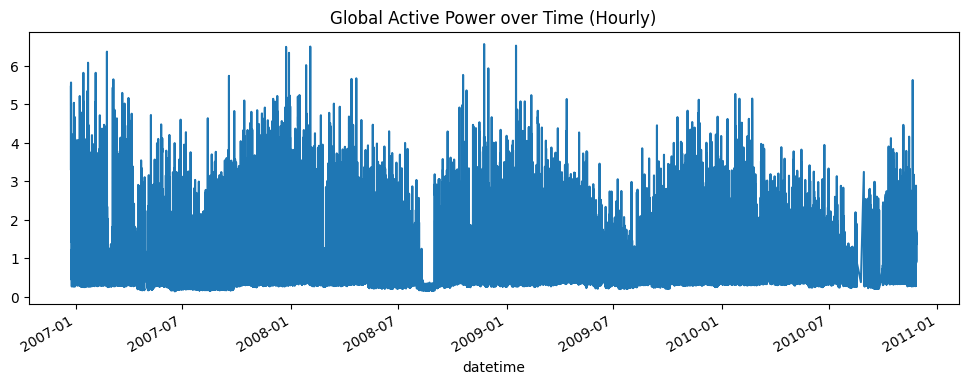

In [ ]:
# Time-series plot
plt.figure(figsize=(12,4))
df_resampled['Global_active_power'].plot()
plt.title("Global Active Power over Time (Hourly)")
plt.show()


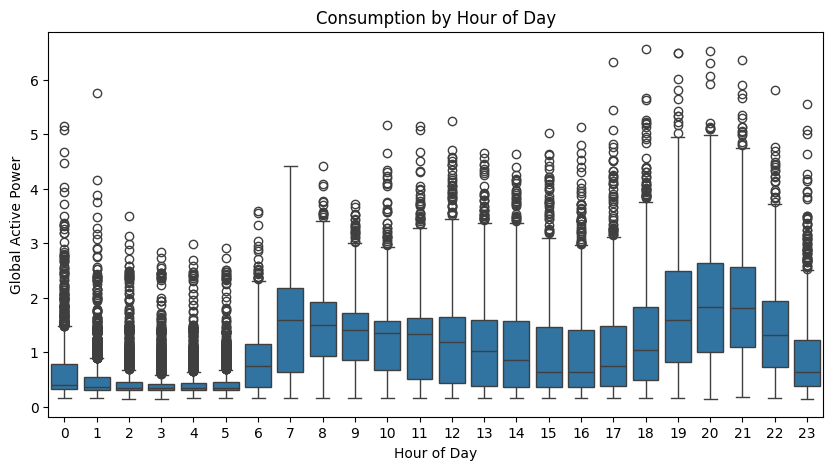

In [ ]:
df_resampled['hour'] = df_resampled.index.hour

# Consumption by hour of day
plt.figure(figsize=(10, 5))
sns.boxplot(x='hour', y='Global_active_power', data=df_resampled.reset_index())
plt.title("Consumption by Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Global Active Power")
plt.show()

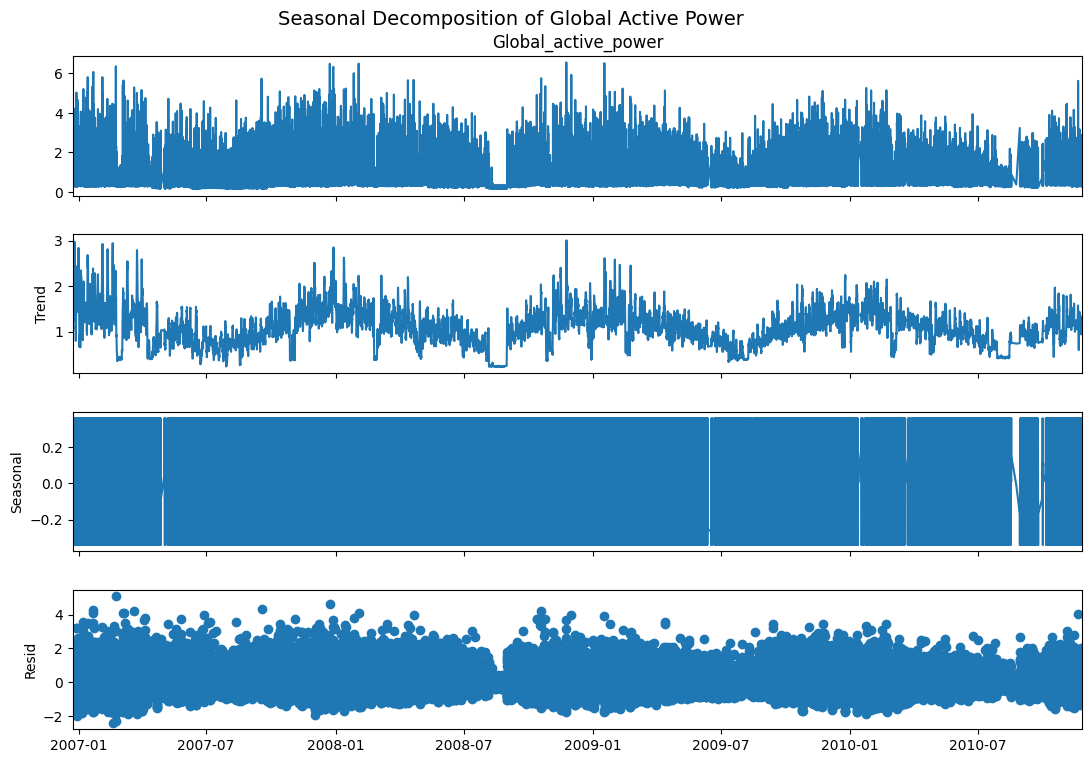

In [ ]:

#  Seasonal decomposition
ts = df_resampled['Global_active_power'].dropna()
result = seasonal_decompose(ts, model='additive', period=24)  # 24 hours for daily seasonality

fig = result.plot()

fig.set_size_inches(12, 8)
plt.suptitle("Seasonal Decomposition of Global Active Power", fontsize=14)
plt.show()

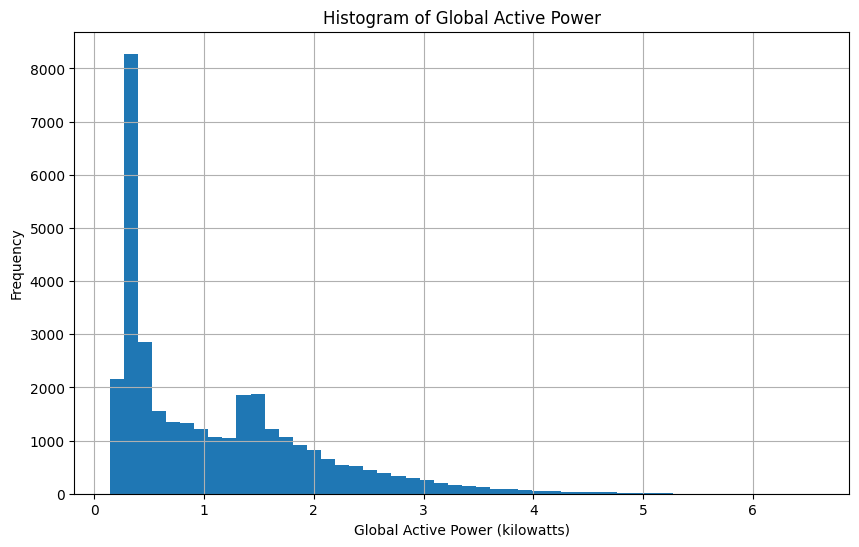

In [ ]:
# Histogram of Global Active Power
plt.figure(figsize=(10, 6))
df_resampled['Global_active_power'].hist(bins=50)
plt.title("Histogram of Global Active Power")
plt.xlabel("Global Active Power (kilowatts)")
plt.ylabel("Frequency")
plt.show()


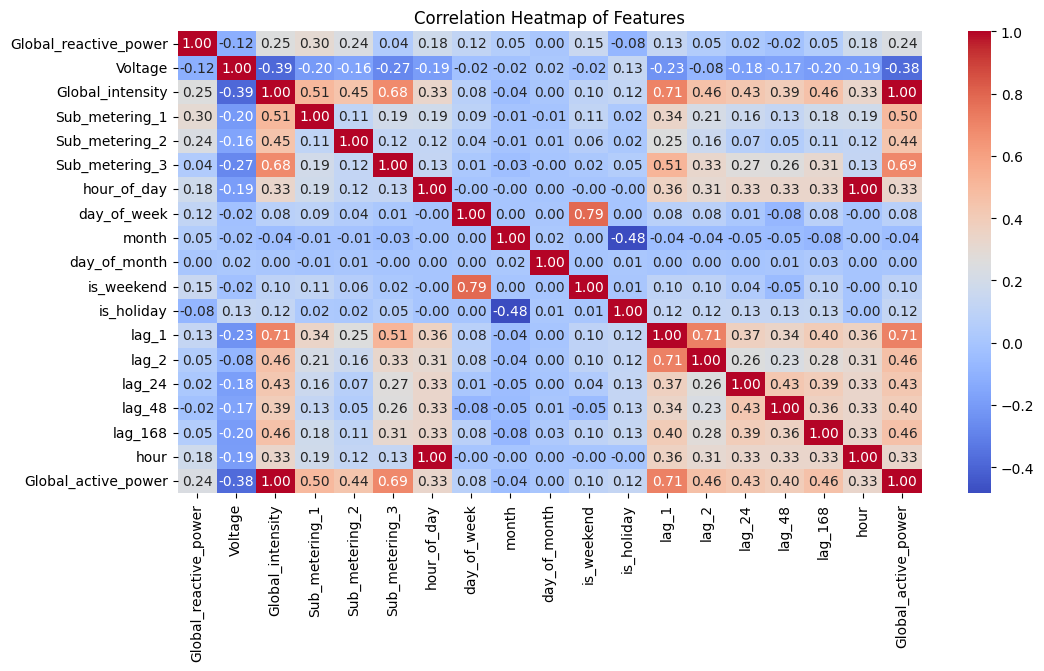

In [ ]:
# Defining the features
features = [col for col in df_resampled.columns if col != 'Global_active_power']

# Correlation heatmap of features
plt.figure(figsize=(12, 6))
correlation = df_resampled[features + ['Global_active_power']].corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Heatmap of Features")
plt.show()


In [ ]:
train_size = int(len(df_resampled) * 0.8)
train = df_resampled.iloc[:train_size]
test = df_resampled.iloc[train_size:]

print("Train size:", train.shape, "Test size:", test.shape)

features = [col for col in df_resampled.columns if col != 'Global_active_power']
X_train, y_train = train[features], train['Global_active_power']
X_test, y_test = test[features], test['Global_active_power']


Train size: (26588, 19) Test size: (6647, 19)


In [ ]:
# SARIMAX Model Implementation
sarimax_model = SARIMAX(train['Global_active_power'],
                        order=(1,0,1), seasonal_order=(1,1,1,24))
sarimax_res = sarimax_model.fit(disp=False)

# Predicting on test data using integer-based index
start = len(train)  # start position (integer index)
end = start + len(test) - 1  # end position (integer index)

sarimax_pred = sarimax_res.predict(start=start, end=end)

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [ ]:
#  Evaluation Function
def evaluate(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"{model_name} -> MAE: {mae:.3f}, RMSE: {rmse:.3f}, R²: {r2:.3f}")
    return mae, rmse, r2

#  Evaluate SARIMAX Model
evaluate(test['Global_active_power'], sarimax_pred, "SARIMAX")

SARIMAX -> MAE: 0.746, RMSE: 0.877, R²: -0.368


(0.7464271398500426, np.float64(0.8773406718126521), -0.36796560209154006)

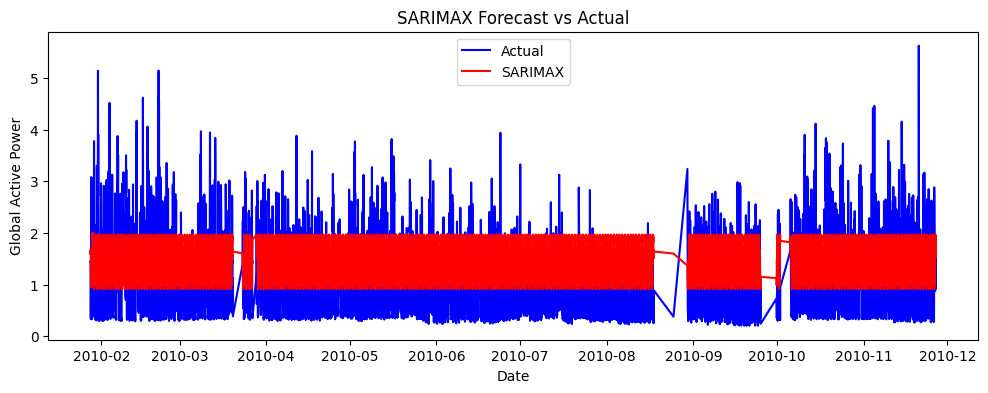

In [ ]:
plt.figure(figsize=(12, 4))

# Plotting actual data
plt.plot(test.index, test['Global_active_power'], label='Actual', color='blue')

# Plotting SARIMAX predicted data
plt.plot(test.index, sarimax_pred, label='SARIMAX', color='red')

# Adding labels and title
plt.xlabel('Date')  # Label for the x-axis
plt.ylabel('Global Active Power')  # Label for the y-axis
plt.title('SARIMAX Forecast vs Actual')  # Title of the plot

# Showing legend
plt.legend()

# Displaying the plot
plt.show()

In [ ]:
#  Feature scaling (StandardScaler) for Random Forest
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(train[features])
X_test_scaled = scaler.transform(test[features])

#  Random Forest Model Implementation
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train_scaled, train['Global_active_power'])

#  Making predictions
rf_pred = rf.predict(X_test_scaled)

In [ ]:
#  Evaluating Random Forest Model ---
evaluate(test['Global_active_power'], rf_pred, "Random Forest")

Random Forest -> MAE: 0.013, RMSE: 0.021, R²: 0.999


(0.013051197655921462, np.float64(0.02134430261803754), 0.9991903401743139)

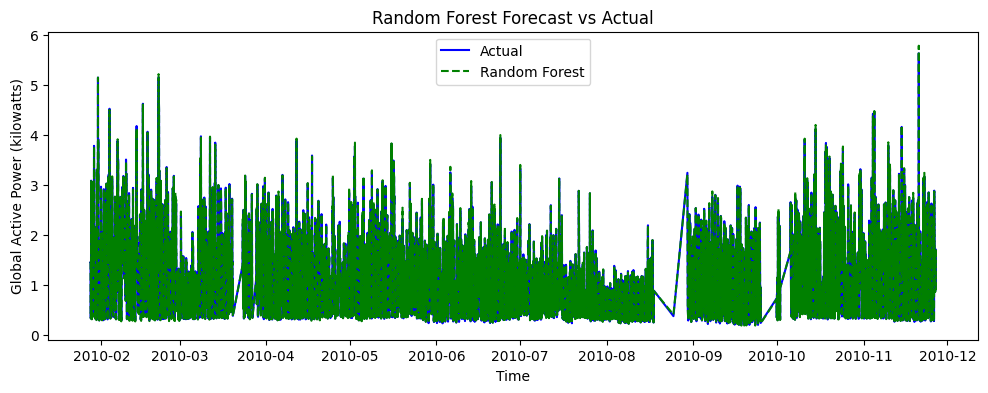

In [ ]:
# Removing any NaN values in the actual data for plotting
test_clean = test.dropna(subset=['Global_active_power'])

# Predictions match the test set index
rf_pred_aligned = pd.Series(rf_pred, index=test_clean.index)

# Plotting Random Forest predictions vs actual
plt.figure(figsize=(12, 4))
plt.plot(test_clean.index, test_clean['Global_active_power'], label='Actual', linestyle='-', color='blue')
plt.plot(rf_pred_aligned.index, rf_pred_aligned, label='Random Forest', linestyle='--', color="green")
plt.legend()
plt.title("Random Forest Forecast vs Actual")
plt.xlabel("Time")
plt.ylabel("Global Active Power (kilowatts)")
plt.show()


In [ ]:
#  Gradient Boosting Model Implementation
gb = GradientBoostingRegressor(n_estimators=200, random_state=42)
gb.fit(X_train_scaled, train['Global_active_power'])

# Predictions
gb_pred = gb.predict(X_test_scaled)

In [ ]:
#  Evaluating Gradient Boosting Model
evaluate(test['Global_active_power'], gb_pred, "Gradient Boosting")

Gradient Boosting -> MAE: 0.013, RMSE: 0.021, R²: 0.999


(0.013140778858139624, np.float64(0.020576638150957748), 0.9992475329415965)

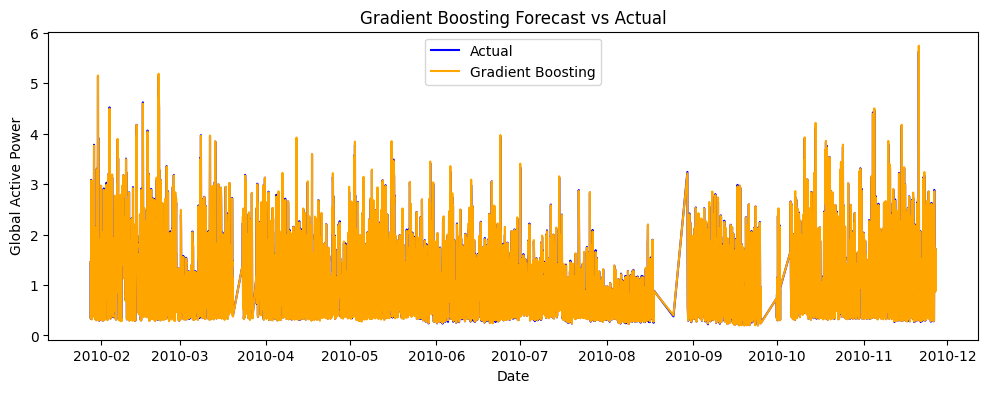

In [ ]:

# gb_pred is your predicted data from Gradient Boosting.
plt.figure(figsize=(12, 4))

# Plot actual data
plt.plot(test.index, test['Global_active_power'], label='Actual', color='blue')

# Plot Gradient Boosting predicted data
plt.plot(test.index, gb_pred, label='Gradient Boosting', color='orange')

# Adding labels and title
plt.xlabel('Date')  # Label for the x-axis
plt.ylabel('Global Active Power')  # Label for the y-axis
plt.title('Gradient Boosting Forecast vs Actual')  # Title of the plot

# Showing legend
plt.legend()


plt.show()

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

#  Evaluation Function
def evaluate(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"{model_name} -> MAE: {mae:.3f}, RMSE: {rmse:.3f}, R²: {r2:.3f}")
    return mae, rmse, r2

# Evaluating SARIMAX Model
sarimax_mae, sarimax_rmse, sarimax_r2 = evaluate(test['Global_active_power'], sarimax_pred, "SARIMAX")

# Evaluating Random Forest Model
rf_mae, rf_rmse, rf_r2 = evaluate(test['Global_active_power'], rf_pred, "Random Forest")

# Evaluating Gradient Boosting Model
gb_mae, gb_rmse, gb_r2 = evaluate(test['Global_active_power'], gb_pred, "Gradient Boosting")

# Comparison of Model Performance
# Creating a DataFrame to compare the results of each model
comparison_df = pd.DataFrame({
    'Model': ['SARIMAX', 'Random Forest', 'Gradient Boosting'],
    'MAE': [sarimax_mae, rf_mae, gb_mae],
    'RMSE': [sarimax_rmse, rf_rmse, gb_rmse],
    'R²': [sarimax_r2, rf_r2, gb_r2]
})

# Sorting by R² (highest R² is better)
comparison_df_sorted = comparison_df.sort_values(by='R²', ascending=False)

# Display the comparison
print("\nModel Comparison (sorted by R²):")
print(comparison_df_sorted)

# Interpretation of Results
best_model = comparison_df_sorted.iloc[0]
print(f"\nThe best model is {best_model['Model']} with the highest R² score of {best_model['R²']:.3f}.")



SARIMAX -> MAE: 0.746, RMSE: 0.877, R²: -0.368
Random Forest -> MAE: 0.013, RMSE: 0.021, R²: 0.999
Gradient Boosting -> MAE: 0.013, RMSE: 0.021, R²: 0.999

Model Comparison (sorted by R²):
               Model       MAE      RMSE        R²
2  Gradient Boosting  0.013141  0.020577  0.999248
1      Random Forest  0.013051  0.021344  0.999190
0            SARIMAX  0.746427  0.877341 -0.367966

The best model is Gradient Boosting with the highest R² score of 0.999.


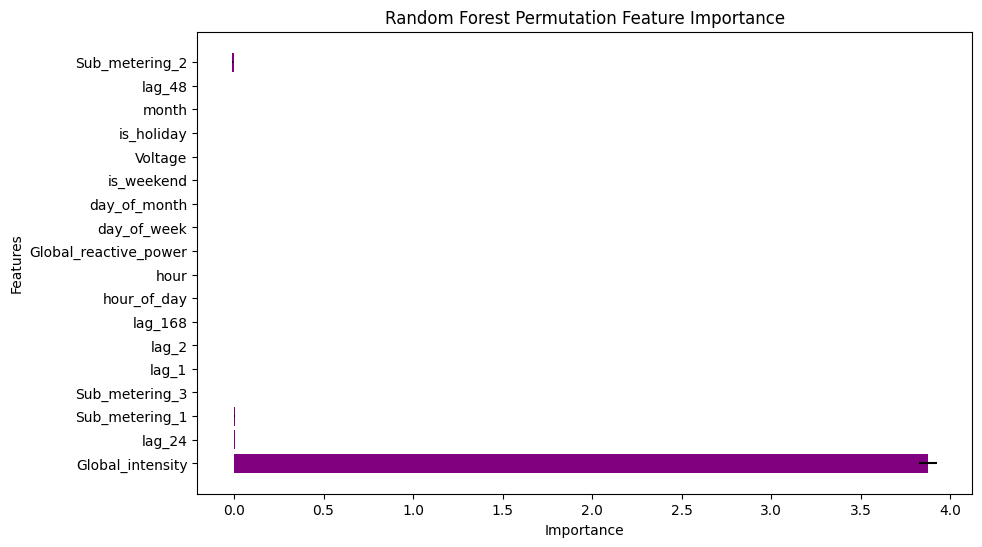

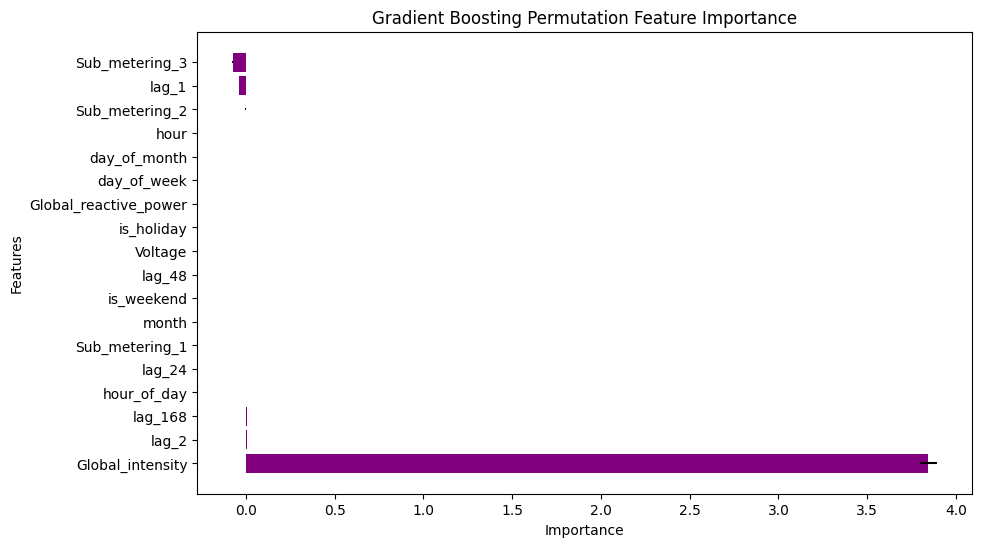

In [ ]:
# Evaluation Function
def evaluate(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    return {'model': model_name, 'MAE': mae, 'RMSE': rmse, 'R²': r2}

# Evaluation of Models
results = []

# Evaluating SARIMAX Model
sarimax_results = evaluate(test['Global_active_power'], sarimax_pred, "SARIMAX")
results.append(sarimax_results)

# Evaluating Random Forest Model
rf_results = evaluate(test['Global_active_power'], rf_pred, "Random Forest")
results.append(rf_results)

# Evaluating Gradient Boosting Model
gb_results = evaluate(test['Global_active_power'], gb_pred, "Gradient Boosting")
results.append(gb_results)

# Converting results to DataFrame for easy comparison
comparison_df = pd.DataFrame(results)

# Sorting by R² (higher R² is better)
comparison_df_sorted = comparison_df.sort_values(by='R²', ascending=False)

# Feature Importance for Tree-based Models
# Random Forest Feature Importance
if hasattr(rf, 'feature_importances_'):
    rf_importances = rf.feature_importances_
    features = test.columns


    if len(rf_importances) == len(features):
        plt.figure(figsize=(10, 6))
        plt.barh(features, rf_importances, color='green')
        plt.title("Random Forest Feature Importance")
        plt.xlabel("Importance")
        plt.ylabel("Features")
        plt.show()

# Gradient Boosting Feature Importance
if hasattr(gb, 'feature_importances_'):
    gb_importances = gb.feature_importances_


    if len(gb_importances) == len(features):
        plt.figure(figsize=(10, 6))
        plt.barh(features, gb_importances, color='orange')
        plt.title("Gradient Boosting Feature Importance")
        plt.xlabel("Importance")
        plt.ylabel("Features")
        plt.show()

# Permutation Feature Importance for Any Model
# Defining function for permutation importance
def permutation_feature_importance(model, X_test, y_test, model_name):
    perm_importance = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)

    #  X_test is a DataFrame with correct feature names
    if isinstance(X_test, np.ndarray):  # If it's a NumPy array, convert it to DataFrame
        X_test = pd.DataFrame(X_test, columns=[f'Feature_{i}' for i in range(X_test.shape[1])])

    # Creating a DataFrame with the feature importance results
    perm_df = pd.DataFrame({
        'Feature': X_test.columns,
        'Importance': perm_importance.importances_mean,
        'Std Dev': perm_importance.importances_std
    })

    # Sorting by Importance
    perm_df_sorted = perm_df.sort_values(by='Importance', ascending=False)

    # Plotting permutation feature importance
    plt.figure(figsize=(10, 6))
    plt.barh(perm_df_sorted['Feature'], perm_df_sorted['Importance'], xerr=perm_df_sorted['Std Dev'], color='purple')
    plt.title(f"{model_name} Permutation Feature Importance")
    plt.xlabel("Importance")
    plt.ylabel("Features")
    plt.show()

# Running Permutation Importance for Random Forest
permutation_feature_importance(rf, X_test, y_test, "Random Forest")

# Running Permutation Importance for Gradient Boosting
permutation_feature_importance(gb, X_test, y_test, "Gradient Boosting")

# Running Permutation Importance for SARIMAX (if applicable)
# permutation_feature_importance(sarimax_model, X_test, y_test, "SARIMAX")

